In [16]:
%qtconsole

In [1]:
import sys
sys.path.append('/home/eric/lib/visual_genome_python_driver_eric')
import src.local as vg

In [2]:
vg_short = '../../data/vg/vg_short/'
json_id_dir = vg_short + 'by-id/'
label_file  = vg_short + 'label_dict.npy'

In [4]:
scene_graphs = vg.GetSceneGraphs(startIndex=0, endIndex=-1,
                                 dataDir=vg_short, imageDataDir=json_id_dir,
                                 minRels=0, maxRels=99999)

100%|██████████| 108077/108077 [15:09<00:00, 118.85it/s]


# Convert data to triplets

In [3]:
import numpy as np
sys.path.append('../..')
from utils import get_sg_data, get_sg_data_mini, rel_coords

In [6]:
scene_graphs = rel_coords(scene_graphs)

In [4]:
label_dict = np.load(label_file).item()

In [18]:
sg_mini = get_sg_data_mini(scene_graphs, label_dict, 
                           mini_file='/home/eric/data/mini/vg2mini.npy')
# sg_data = {'obj': obj_data, 'rel': rel_data}

In [19]:
print len(sg_mini['obj']), len(sg_mini['rel'])

313372 156686


In [21]:
np.save('/home/eric/data/vg/mini_data.npy', sg_mini)

In [ ]:
fnames = set( [i[0]       for i in sg_mini['obj']] + \
              [j[0][0][0] for j in sg_mini['rel']]   )

train_ratio = 0.8
n_train = int(len(fnames) * train_ratio)

train_fnames = np.random.choice(list(fnames), n_train, replace=False)

In [28]:
print len(fnames), len(train_fnames)

45379 36303


In [32]:
vg_train = {'obj': [d for d in sg_mini['obj'] if d[0]       in train_fnames],
            'rel': [d for d in sg_mini['rel'] if d[0][0][0] in train_fnames] }
vg_test  = {'obj': [d for d in sg_mini['obj'] if d[0]       not in train_fnames],
            'rel': [d for d in sg_mini['rel'] if d[0][0][0] not in train_fnames] }

In [35]:
print len(vg_train['obj']), len(vg_train['rel'])
print len(vg_test['obj']),  len(vg_test['rel'])

250752 125376
62620 31310


In [33]:
np.save('/home/eric/data/mini/vg_train.npy', vg_train)
np.save('/home/eric/data/mini/vg_test.npy',  vg_test)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


In [9]:
print len(sg_data['obj']), len(sg_data['rel'])

3 3


In [93]:
np.save('/home/eric/data/vg/full_data_.npy', sg_data)

In [5]:
sg_data = np.load('/home/eric/data/vg/full_data_.npy').item()

In [14]:
R_full = np.zeros((637,637,83))

for _,k,uid in sg_data['rel']:
    if len(uid) > 1:
        (_,i,_), (_,j,_) = list(uid)
    else:
        (_,i,_) = list(uid)[0]    # Reflexive predicates
        j = i
    R_full[i,j,k] += 1

In [18]:
mini2vg = np.load('/home/eric/data/mini/mini2vg.npy').item()

In [23]:
R_mini = np.zeros((637,637,83))

for _,k,uid in sg_mini['rel']:
    if len(uid) > 1:
        (_,i,_), (_,j,_) = list(uid)
    else:
        (_,i,_) = list(uid)[0]    # Reflexive predicates
        j = i
    i_,j_,k_ = (mini2vg['obj'][i], mini2vg['obj'][j], mini2vg['rel'][k])
    R_mini[i_,j_,k_] += 1

In [26]:
Y_full = R_full.sum(axis=(0,1))
Y_mini = R_mini.sum(axis=(0,1))
labels = [label_dict2['rel'][k] for k in range(83)]

Y_full, Y_mini, labels = zip(*sorted(zip(Y_full, Y_mini, labels), reverse=True))

data = [go.Bar(name='Full VG',
               x=range(83), 
               y=Y_full,
               text=labels),
        go.Bar(name='Mini VG',
               x=range(83), 
               y=Y_mini,
               text=labels),
       ]
layout = go.Layout(title='Predicate Synsets in Visual Genome',
                   autosize=False, width=700, height=400,
                   xaxis={'title':'Synset'}, yaxis={'title':'Frequency'})

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='fullvg_hist')

In [18]:
labels = [label_dict2['obj'][i] for i in range(637)]
data = [go.Bar(name='subject',
               x=range(637), 
               y=R_full.sum(axis=(1,2)),
               text=labels),
        go.Bar(name='object',
               x=range(637), 
               y=R_full.sum(axis=(0,2)),
               text=labels)]
layout = go.Layout(title='Predicates in Full ShortVG Dataset',
                   autosize=False, width=700, height=400)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='fullvg_so_hist')

# Prune & re-label triplets for MiniVG

In [8]:
vid2sid = np.load('/home/eric/data/v2v/vid2sid.npy').item()

vg2mini = {'obj': {i:idx for idx, i in enumerate(set(vid2sid['obj'].values()))},
           'rel': {i:idx for idx, i in enumerate(set(vid2sid['rel'].values()))}}

mini2vg = {'obj': {idx:i for idx, i in enumerate(set(vid2sid['obj'].values()))},
           'rel': {idx:i for idx, i in enumerate(set(vid2sid['rel'].values()))}}

In [122]:
sg_mini = {'obj': [], 'rel': []}

for sg in scene_graphs:
    fname = sg.image.url.split('/')[-1]

    for r in sg.relationships:
        s, o = (r.subject, r.object)

        i = [label_dict['obj'][sy] for sy in s.synsets if sy in label_dict['obj']][0]
        j = [label_dict['obj'][sy] for sy in o.synsets if sy in label_dict['obj']][0]
        k = [label_dict['rel'][sy] for sy in r.synset  if sy in label_dict['rel']][0]

        if (i in vg2mini['obj']) and (j in vg2mini['obj']) and (k in vg2mini['rel']):
            i_ = vg2mini['obj'][i]
            j_ = vg2mini['obj'][j]
            k_ = vg2mini['rel'][k]
        
            s_coords = (s.x, s.y, s.width, s.height)
            o_coords = (o.x, o.y, o.width, o.height)
            r_coords = (r.x, r.y, r.width, r.height)

            s_uid = ( fname,  i_,  s_coords )
            o_uid = ( fname,  j_,  o_coords )
            r_uid = frozenset((s_uid, o_uid))

            sg_mini['obj'].append((s_coords, i_, s_uid))
            sg_mini['obj'].append((o_coords, j_, o_uid))
            sg_mini['rel'].append((r_coords, k_, r_uid))

In [60]:
np.save('/home/eric/data/mini/vg.npy', sg_mini)

In [123]:
print len(sg_mini['obj']), len(sg_mini['rel'])

313372 156686


In [52]:
np.save('/home/eric/data/vg/mini_data1.npy', sg_mini)

# TODO

- look at category historgrams
- stratified sampling?


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
sg_mini = np.load('/home/eric/data/vg/mini_data1.npy').item()

In [13]:
import plotly.graph_objs as go
from plotly.plotly import plot, iplot
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode()

In [8]:
label_dict2 = {'obj': {v:k for k,v in label_dict['obj'].items()},
               'rel': {v:k for k,v in label_dict['rel'].items()}}

In [15]:
N, K = (len(vg2mini['obj']), len(vg2mini['rel']))
R = np.zeros((N,N,K))

for _,k,uid in sg_mini['rel']:
    if len(uid) > 1:
        (_,i,_), (_,j,_) = list(uid)
    else:
        (_,i,_) = list(uid)[0]    # Reflexive predicates
        j = i
    R[i,j,k] += 1

In [16]:
labels = [label_dict2['rel'][mini2vg['rel'][k]] for k in range(K)]

Y, labels = zip(*sorted(zip(R.sum(axis=(0,1)), labels), reverse=True))

data = [go.Bar(x=range(K), 
               y=Y,
               text=labels) ]
layout = go.Layout(title='Predicates Synsets in MiniVG',
                   autosize=False, width=700, height=400)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='minivg_hist')

In [5]:
D['obj'].values()[3]

[(u'2380642.jpg', (407, 294, 64, 51), 4),
 (u'2380642.jpg', (392, 64, 74, 203), 5),
 (u'2380642.jpg', (407, 294, 64, 51), 4),
 (u'2380642.jpg', (419, 345, 77, 71), 23),
 (u'2380642.jpg', (392, 64, 74, 203), 5),
 (u'2380642.jpg', (419, 345, 77, 71), 23),
 (u'2380642.jpg', (392, 64, 74, 203), 5),
 (u'2380642.jpg', (419, 345, 77, 71), 23),
 (u'2380642.jpg', (392, 64, 74, 203), 5),
 (u'2380642.jpg', (7, 273, 488, 140), 23),
 (u'2380642.jpg', (10, 6, 322, 253), 91),
 (u'2380642.jpg', (419, 345, 77, 71), 23),
 (u'2380642.jpg', (1, 0, 305, 256), 91),
 (u'2380642.jpg', (137, 290, 361, 120), 23),
 (u'2380642.jpg', (208, 310, 203, 78), 67),
 (u'2380642.jpg', (419, 345, 77, 71), 23)]

In [7]:
vg['obj'][0]

((53, 80, 40, 190), 31, (u'2407173.jpg', 31, (53, 80, 40, 190)))

In [61]:
# import numpy as np
from collections import defaultdict

# sg_data = np.load('/home/eric/data/vg/full_data_.npy').item()
# sg_mini = np.load('/home/eric/data/vg/mini_data1.npy').item()


# list(vg['rel'][0][2])[0]


D = {'obj': defaultdict(lambda: list()), 'rel': defaultdict(lambda: list())}


for d in sg_mini['obj']:
    _, _, ouid = d
    fn, i, coords = ouid
    D['obj'][fn].append((fn, coords, i))

for d in sg_mini['rel']:
    coords, k, ruid = d
    ruid = frozenset([(f, co, lab) for f,lab,co in ruid])
    fn = list(ruid)[0][0]
    D['rel'][fn].append((ruid, coords, k))
    
    

In [20]:
n_train

36303

In [10]:
len(fnames)

45379

In [22]:
fnames = set(D['obj'].keys() + D['rel'].keys())

train_ratio = 0.8
n_train = int(len(fnames) * train_ratio)


train_fnames = np.random.choice(list(fnames), n_train, replace=False)

vg_train = {'obj': [q for fn, d in D['obj'].items() for q in d if fn in train_fnames],
            'rel': [q for fn, d in D['rel'].items() for q in d if fn in train_fnames] }
vg_test  = {'obj': [q for fn, d in D['obj'].items() for q in d if fn not in train_fnames],
            'rel': [q for fn, d in D['rel'].items() for q in d if fn not in train_fnames] }

np.save('/home/eric/data/mini/vg_train.npy', vg_train)
np.save('/home/eric/data/mini/vg_test.npy',  vg_test)

NameError: name 'fnames' is not defined

In [66]:
np.save('/home/eric/data/mini/vg_train.npy', vg_train)
np.save('/home/eric/data/mini/vg_test.npy',  vg_test)

In [27]:
print len(vg_train['obj']), len(vg_train['rel'])
print len(vg_test['obj']),  len(vg_test['rel'])

250510 125255
62862 31431


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


In [217]:
sorted(zip(R.sum(axis=(0,1)), labels, range(40)))

[(17.0, 'hold.v.03', 31),
 (35.0, 'reach.v.01', 13),
 (48.0, 'incorporate.v.02', 29),
 (56.0, 'talk.v.01', 28),
 (111.0, 'play.v.01', 11),
 (112.0, 'refer.v.02', 26),
 (124.0, 'use.v.01', 8),
 (136.0, 'outside.r.01', 5),
 (138.0, 'confront.v.02', 16),
 (195.0, 'watch.v.01', 20),
 (214.0, 'across.r.01', 21),
 (214.0, 'drive.v.01', 0),
 (214.0, 'front.v.01', 23),
 (234.0, 'pull.v.01', 10),
 (287.0, 'look.v.02', 37),
 (294.0, 'park.v.01', 19),
 (361.0, 'lie.v.01', 30),
 (402.0, 'attach.v.01', 17),
 (464.0, 'eat.v.01', 15),
 (511.0, 'inside.r.01', 7),
 (516.0, 'transport.v.02', 9),
 (522.0, 'traverse.v.01', 36),
 (625.0, 'below.r.01', 22),
 (844.0, 'over.r.01', 27),
 (1026.0, 'walk.v.01', 35),
 (1088.0, 'fly.v.01', 2),
 (1470.0, 'depend_on.v.01', 33),
 (1690.0, 'above.r.01', 6),
 (1727.0, 'stand.v.01', 4),
 (2456.0, 'by.r.01', 1),
 (2683.0, 'under.r.01', 24),
 (3335.0, 'sit.v.01', 39),
 (3865.0, 'next.r.01', 3),
 (4383.0, 'about.r.07', 14),
 (6022.0, 'behind.r.01', 38),
 (8901.0, 'wear.v.0

In [175]:
# Delete these verbs that have less than 100 training points

# (17.0, hold:31),(35.0, reach:13),(48.0, incorporate:29),(56.0, talk:28)
removes = [13, 28, 29, 31]

for r in removes:
    del sg_mini['rel'][r]


In [168]:
print len(sg_mini['obj']), len(sg_mini['rel'])     # number of remaining obj/rels
print np.sum(sorted(R.sum(axis=(0,1)))[4:])        # number of remaining relationship data

313372 156686
156530.0


In [198]:
vid2sid = np.load('/home/eric/data/v2v/vid2sid.npy').item()

In [209]:
sid2vid = {'obj': {s:v for v,s in vid2sid['obj'].items()},
           'rel': {s:v for v,s in vid2sid['rel'].items()} }

np.save('/home/eric/data/v2v/sid2vid.npy', sid2vid)

In [213]:
# Original mini indices ranging from [0, 39]
mini2vg = {'obj' : {idx:i for idx, i in enumerate(set(vid2sid['obj'].values()))},
           'rel' : {idx:i for idx, i in enumerate(set(vid2sid['rel'].values()))}}
np.save('/home/eric/data/v2v/mini2vg.npy',  mini2vg)

vg2mini = {'obj': {i:idx for idx, i in mini2vg['obj'].items()},
           'rel': {i:idx for idx, i in mini2vg['rel'].items()} }
np.save('/home/eric/data/v2v/vg2mini.npy',  vg2mini)

mini2vrd = { 'obj': {idx : sid2vid['obj'][i] for idx, i in mini2vg['obj'].items() },
             'rel': {idx : sid2vid['rel'][i] for idx, i in mini2vg['rel'].items() } }
np.save('/home/eric/data/v2v/mini2vrd.npy', mini2vrd)

vrd2mini = {'obj': {i:i_ for i_, i in mini2vrd['obj'].items()},
            'rel': {i:i_ for i_, i in mini2vrd['rel'].items()} }
np.save('/home/eric/data/v2v/vrd2mini.npy',  vrd2mini)

In [192]:
for r in removes:
    del mini2vg['rel'][r]
    
# New indices ranging [0,35]
mini2vg2 = {'obj' : { idx:i for idx, i in enumerate(set(mini2vg['obj'].values())) },
            'rel' : { idx:i for idx, i in enumerate(set(mini2vg['rel'].values())) }}

np.save('/home/eric/data/v2v/mini2vg2.npy',  mini2vg2)

# MiniVRD

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import loadmat, mat_to_triplets

In [5]:
# Load data
mat_dir = '../../data/vrd/mat/'
obj_mat   = mat_dir + 'objectListN.mat'
rel_mat   = mat_dir + 'predicate.mat'
train_mat = mat_dir + 'annotation_train.mat'
test_mat  = mat_dir + 'annotation_test.mat'

obj_dict = {r:i for i,r in enumerate(loadmat(obj_mat)['objectListN'])}
rel_dict = {r:i for i,r in enumerate(loadmat(rel_mat)['predicate'])}
word2idx = {'obj':obj_dict, 'rel':rel_dict}

obj_dict2 = {i:r for i,r in enumerate(loadmat(obj_mat)['objectListN'])}
rel_dict2 = {i:r for i,r in enumerate(loadmat(rel_mat)['predicate'])}
idx2word = {'obj':obj_dict2, 'rel':rel_dict2}

mat_train = loadmat(train_mat)['annotation_train']
D_train   = mat_to_triplets(mat_train, word2idx)

mat_test = loadmat(test_mat)['annotation_test']
D_test   = mat_to_triplets(mat_test, word2idx)

In [6]:
V = np.load('/home/eric/data/mini/vrd2mini.npy').item()

In [8]:
# Triplet data format:
#   ( (i,j,k), sub_uid, obj_uid )
 
D_mini_T = {
    'train' : {'obj': set(), 'rel': []},
    'test'  : {'obj': set(), 'rel': []}
}
D = {'train': D_train, 'test': D_test}

for t, D_ in D.items():

    for d in D_:
        trip, suid, ouid = d
        i,j,k = trip
        
        sx, sy, sw, sh = suid[1]
        ox, oy, ow, oh = ouid[1]
        rx = min(sx, ox)
        ry = min(sy, oy)
        rw = max(sx + sw, ox + ow) - rx
        rh = max(sy + sh, oy + oh) - ry

        vr, vo = (V['rel'], V['obj'])
        if (i in vo) and (j in vo) and (k in vr):
            
            trip_ = (vo[i], vo[j], vr[k])
            suid = suid[:2] + (vo[i],)
            ouid = ouid[:2] + (vo[j],)
            
            ruid = (suid, ouid)
            rcoords = (rx, ry, rw, rh)
            
            D_mini_T[t]['rel'].append((trip_, suid, ouid))
            D_mini_T[t]['obj'].update({suid, ouid})
            
D_mini_T['train'] = {k : list(v) for k,v in D_mini_T['train'].items()}
D_mini_T['test']  = {k : list(v) for k,v in D_mini_T['test'].items()}  

In [9]:
np.save('/home/eric/data/mini/vrd_train2trips.npy', D_mini_T['train'])
np.save('/home/eric/data/mini/vrd_test2trips.npy',  D_mini_T['test'])

In [10]:
  
D_mini = {
    'train' : {'obj': set(), 'rel': []},
    'test'  : {'obj': set(), 'rel': []}
}
D = {'train': D_train, 'test': D_test}

for t, D_ in D.items():

    for d in D_:
        trip, suid, ouid = d
        i,j,k = trip
        
        sx, sy, sw, sh = suid[1]
        ox, oy, ow, oh = ouid[1]
        rx = min(sx, ox)
        ry = min(sy, oy)
        rw = max(sx + sw, ox + ow) - rx
        rh = max(sy + sh, oy + oh) - ry

        vr, vo = (V['rel'], V['obj'])
        if (i in vo) and (j in vo) and (k in vr):
            
            trip_ = (vo[i], vo[j], vr[k])
            suid = suid[:2] + (vo[i],)
            ouid = ouid[:2] + (vo[j],)
            
            ruid = (suid, ouid)
            rcoords = (rx, ry, rw, rh)
            
            D_mini[t]['rel'].append((ruid, rcoords, vr[k]))
            D_mini[t]['obj'].update({suid, ouid})
            
D_mini['train'] = {k : list(v) for k,v in D_mini['train'].items()}
D_mini['test']  = {k : list(v) for k,v in D_mini['test'].items()}

In [11]:
np.save('/home/eric/data/mini/vrd_train2.npy', D_mini['train'])
np.save('/home/eric/data/mini/vrd_test2.npy',  D_mini['test'])

In [12]:
print len(D_train), len(D_mini['train']['obj'])
print len(D_test), len(D_mini['test']['obj'])

30355 20709
7638 5310


In [10]:
w2v_vrd = np.load('/home/eric/data/vrd/w2v.npy').item()

In [17]:
w2v_vg = np.load('/home/eric/data/vg_short/word2vec.npy').item()
w2v_vg = {'obj': np.vstack(zip(*sorted(w2v_vg['obj'].items()))[1]),
          'rel': np.vstack(zip(*sorted(w2v_vg['rel'].items()))[1]) }

In [21]:
np.save('/home/eric/data/vg/w2v.npy', w2v_vg)

In [ ]:
w2v_m_vg = sorted([(vg2mini['obj'][k], vec) for k, vec in w2v_vg['obj'].items() 
                                            if k in vg2mini['obj']])



<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


# load FULL data!

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [26]:
data_dir = '../../data/vg/'

json_dir    = data_dir+'json/'
json_id_dir = data_dir+'json/by-id/'
obj_file    = data_dir+'models/objnet/vg_obj_probs.npy'
rel_file    = data_dir+'models/relnet/vg_rel_feats.npy'

In [13]:
scene_graphs = vg.GetSceneGraphs(startIndex=0, endIndex=100,
                                 dataDir=json_dir, imageDataDir=json_id_dir,
                                 minRels=1, maxRels=100)

In [174]:
def jitter(arr, stdev=1.0):
    return arr + np.random.randn(len(arr)) * stdev

def visualize_objects(img, objects, stdev=4.0):
    fig = plt.gcf()
    ratio = 18.5 / 10.5
    fig.set_size_inches(15*ratio, 15.)

    ##TODO: are all imgs .png ???
    plt.imshow(img)
    cmap = plt.cm.rainbow(np.linspace(0,1,len(objects)))
    ax = plt.gca()
    
    for i, obj in enumerate(sorted(objects, key=lambda x: np.random.rand())):
        ax.add_patch(Rectangle((obj.x, obj.y),
                               obj.width,
                               obj.height,
                               fill=False,
                               alpha=0.8,
                               edgecolor=cmap[i],
                               #linestyle='--',
                               linewidth=5))
        x_, y_ = jitter([obj.x, obj.y], stdev=stdev)
        s = str(obj.synsets) #= str(obj.id) + ' : ' + str(obj.names[0])
        ax.text(x_, y_, s, weight='bold', style='italic', 
                           bbox={'facecolor':'white', 'alpha':0.9, 'pad':2, 'edgecolor':cmap[i], 'linewidth':2})
        
    fig = plt.gcf()
    plt.tick_params(labelbottom='off', labelleft='off')
    plt.show()

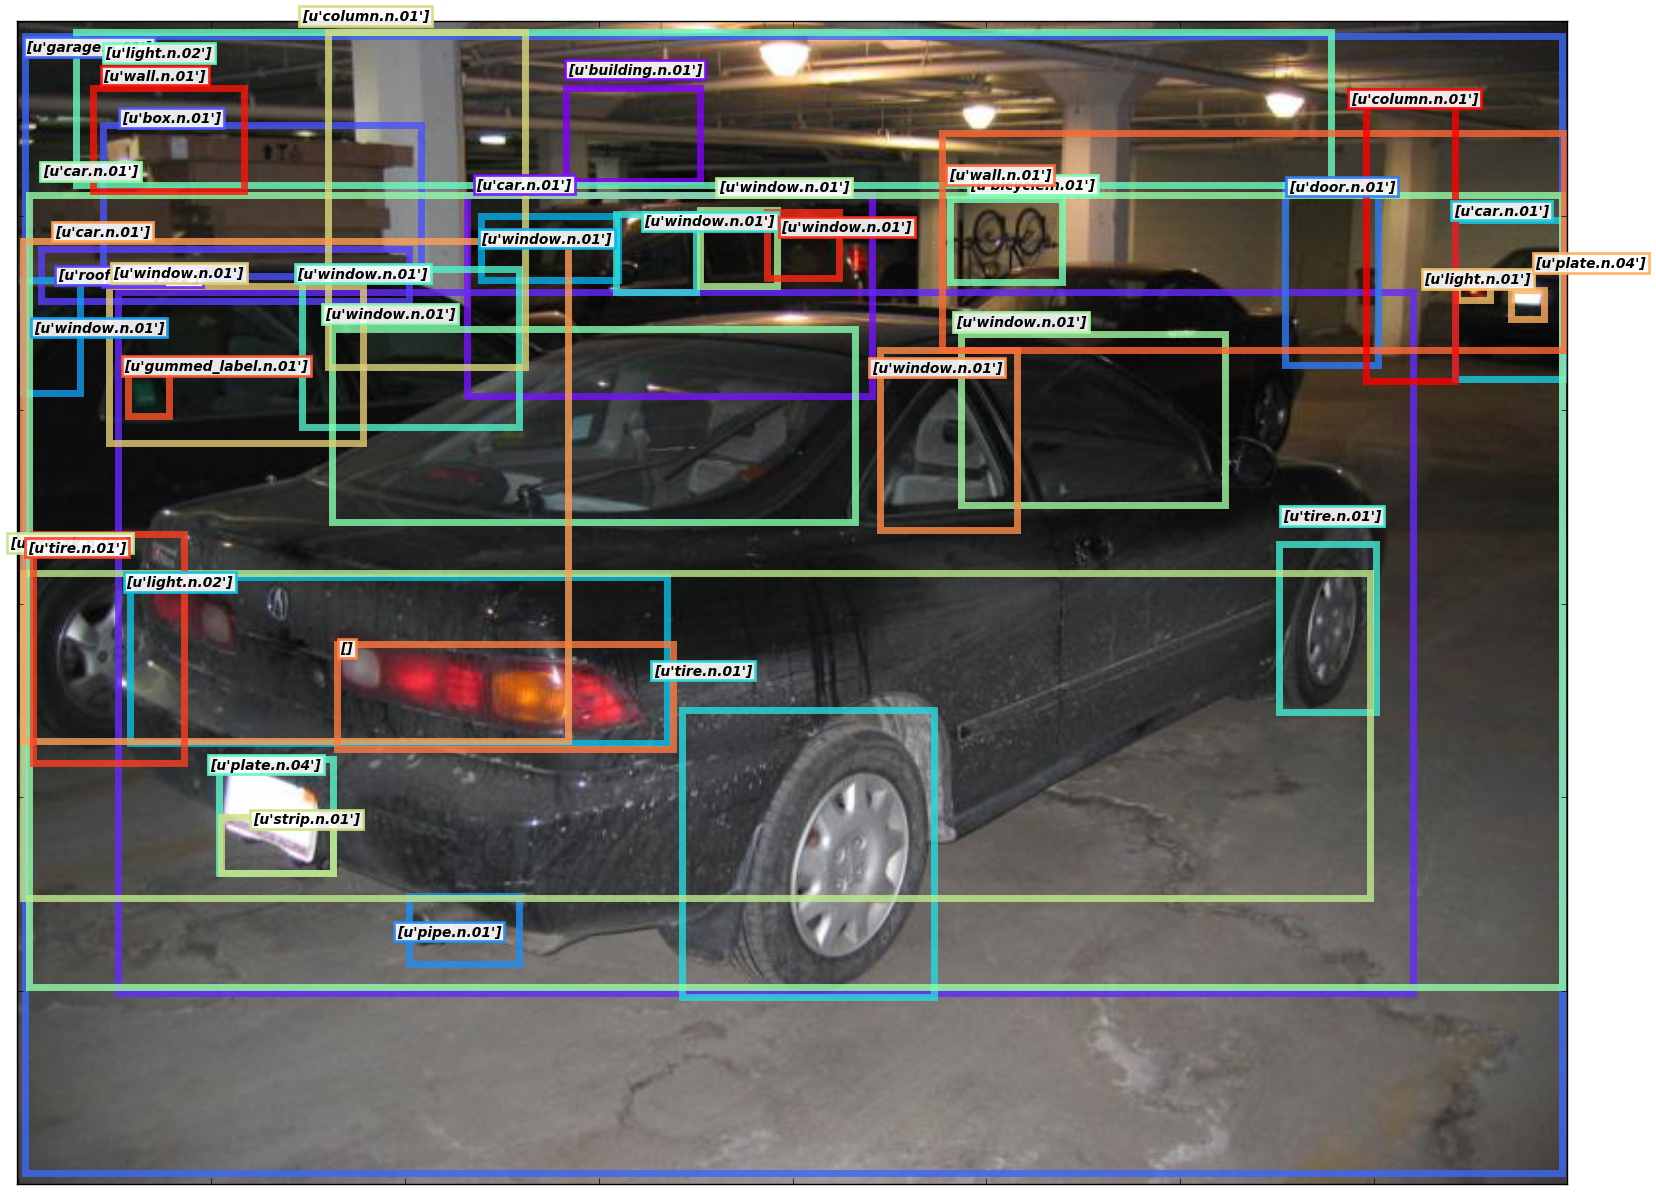

In [177]:
sg = scene_graphs[46]
objects = sg.objects
img = plt.imread(data_dir+'images/{}.jpg'.format(sg.image.id))

N = -1
visualize_objects(img, objects[:], stdev=10.0)

# Relationships

In [129]:
scene_graphs = rel_coords(scene_graphs)

In [128]:
def rel_coords(scene_graphs):
    for sg in scene_graphs:
        for r in sg.relationships:
            s = r.subject
            o = r.object
            r.x = min(s.x, o.x)
            r.y = min(s.y, o.y)
            r.width  = max(s.x + s.width,  o.x + o.width ) - r.x
            r.height = max(s.y + s.height, o.y + o.height) - r.y

    return scene_graphs

In [172]:
def visualize_rels(img, rels, stdev=4.0):
    fig = plt.gcf()
    ratio = 18.5 / 10.5
    fig.set_size_inches(15*ratio, 15.)

    ##TODO: are all imgs .png ???
    plt.imshow(img)
    cmap = plt.cm.rainbow(np.linspace(0,1,len(rels)))
    ax = plt.gca()
    
    for i, rel in enumerate(sorted(rels, key=lambda x: np.random.rand())):
        ax.add_patch(Rectangle((rel.x, rel.y),
                               rel.width,
                               rel.height,
                               fill=False,
                               alpha=0.8,
                               edgecolor=cmap[i],
                               #linestyle='--',
                               linewidth=5))
        x_, y_ = jitter([rel.x, rel.y], stdev=stdev)
#         s = str(rel) #= str(obj.id) + ' : ' + str(obj.names[0])
        s = str((rel.subject.synsets, rel.synset, rel.object.synsets))
        ax.text(x_, y_, s, weight='bold', style='italic', 
                           bbox={'facecolor':'white', 'alpha':0.9, 'pad':2, 'edgecolor':cmap[i], 'linewidth':2})
        
    fig = plt.gcf()
    plt.tick_params(labelbottom='off', labelleft='off')
    plt.show()

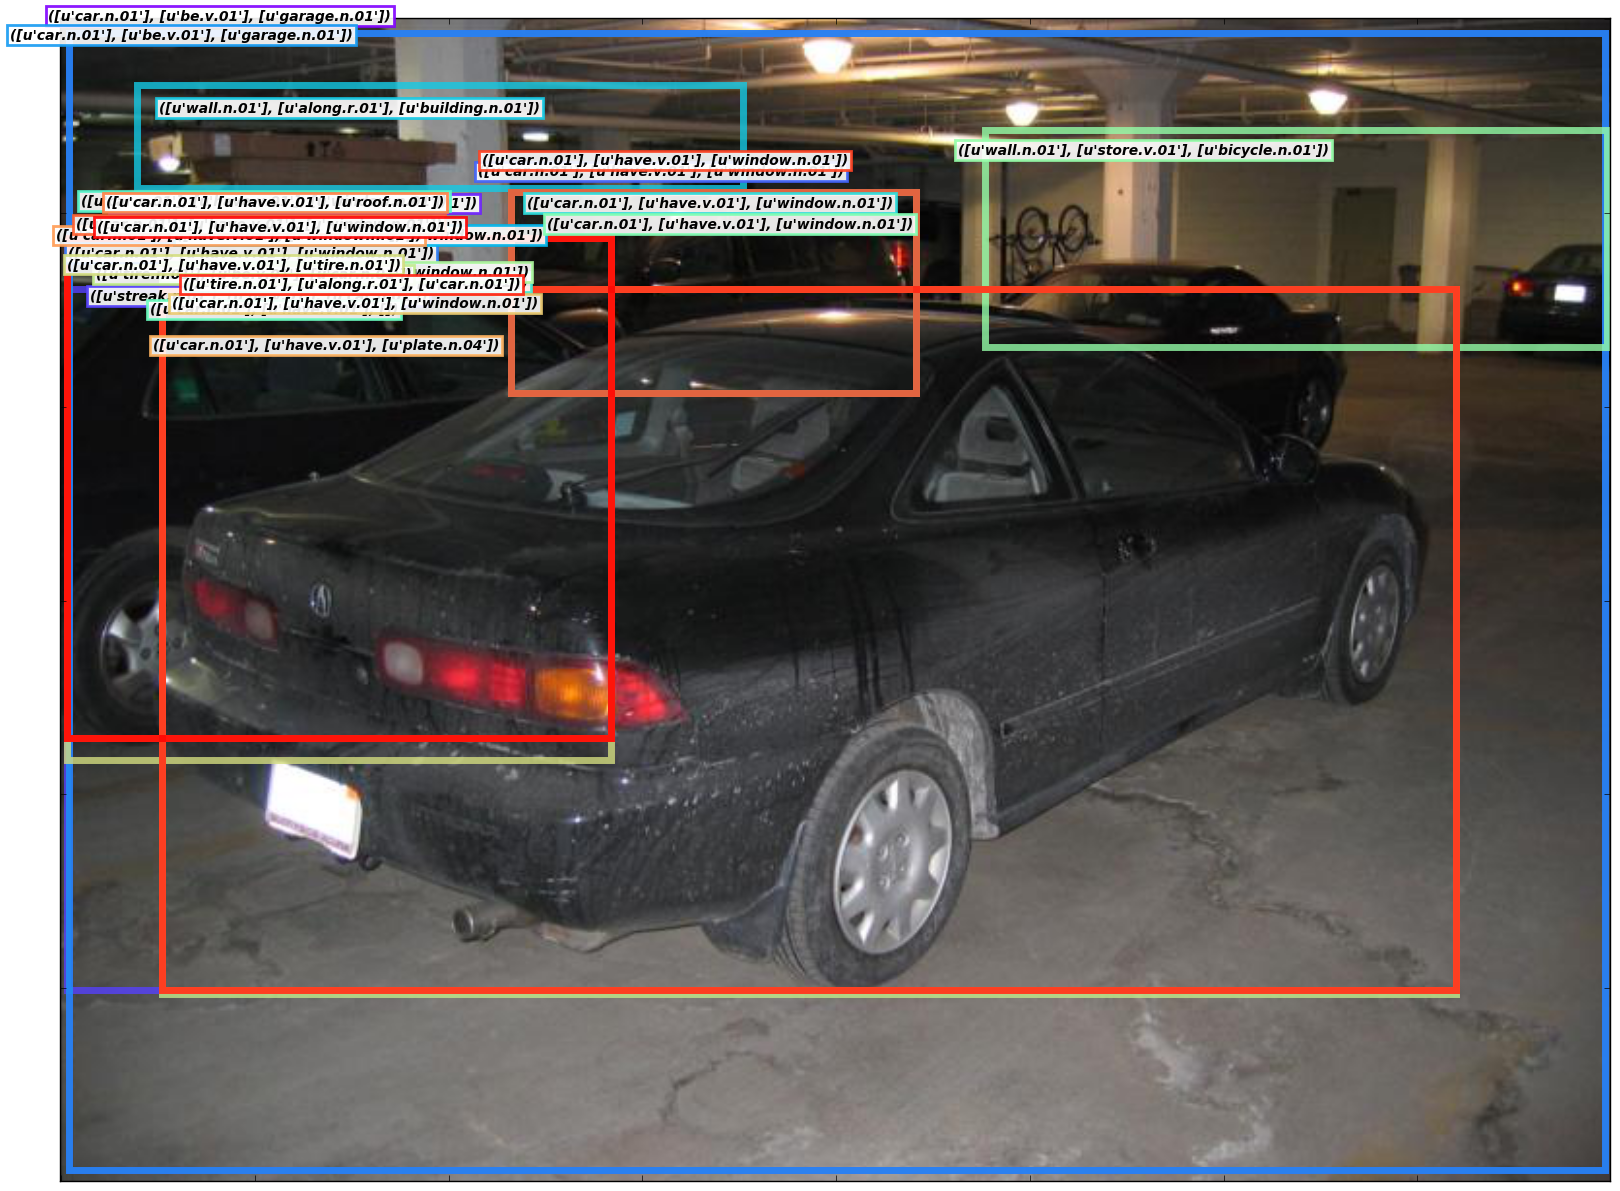

In [173]:
sg = scene_graphs[46]
rels = sg.relationships
img = plt.imread(data_dir+'images/{}.jpg'.format(sg.image.id))

N = -1
visualize_rels(img, rels[:], stdev=15.0)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# scrap

In [ ]:
from utils import loadmat
obj_dict = {r:i for i,r in enumerate(loadmat(obj_mat)['objectListN'])}
rel_dict = {r:i for i,r in enumerate(loadmat(rel_mat)['predicate'])}

word2idx = {'obj':obj_dict, 'rel':rel_dict}
np.save(w2idx_file, word2idx)